# 📌 Connexion au Notebook avec Singularity

## 🔹 Image Singularity  
Lancer l'image Singularity suivante :  
`6_Containers/shortcakelight.sif`  

[ShortCake](https://github.com/rnakato/ShortCake/tree/master) est conçu spécifiquement pour les analyses de données single-cell.  

---

## 🚀 Lancement de l'image et connexion au Jupyter Notebook  

### Lancer l'image Singularity  
```bash
srun --pty bash
singularity exec 6_Containers/shortcakelight.sif jupyternotebook.sh
```
##3 Puis faire le lien ssh sur l'ordi avec cette commande que l'on écrit dans le terminal local:
```bash
ssh -A -t -t vgoupille@genossh.genouest.org -L 8888:localhost:8888 ssh cl1n030 -L 8888:localhost:8888
modifier le port (numero et noeud si besoin)
```

## si probleme de connection 

```bash
ls -a
rm -r .vscode-server
#puis se remet sur vscode 
# et refait la liaison avec ssh remote (et reinstaller les extensions...)
```

Ce texte décrit les stratégies et les méthodes utilisées pour traiter et aligner les données issues de l’expérience scRNA-seq réalisée avec la méthode microSPLiT.

1. **Stratégie de séquençage (Library strategy)** :
	- La méthode utilisée est microSPLiT, qui est une adaptation de la technique SPLiT-seq, permettant de réaliser du scRNA-seq sans nécessiter d’isolation physique des cellules.

2. **Prétraitement et alignement des données** :
	- L’alignement des séquences a été effectué avec une version modifiée du pipeline SPLiT-seq disponible sur GitHub (https://github.com/Alex-Rosenberg/split-seq-pipeline).
	- Modifications apportées :
	  - Utilisation de STAR (un logiciel d’alignement des lectures RNA-seq) avec une détection des isoformes d’épissage.
	  - Sélection des meilleurs alignements multimapping selon un critère de score élevé.
	  - Conservation d’un compte fonctionnel basé sur le nombre d’alignements de bonne qualité, ce qui est pertinent pour les génomes bactériens où plusieurs CDSs (séquences codantes) peuvent se chevaucher.

3. **Références génomiques utilisées** :
	- Les génomes de référence utilisés pour l’alignement sont :
	  - ASM904v1.45
	  - ASM80076v1.37
	- Ces versions proviennent de la base de données EnsemblBacteria.

4. **Fichiers supplémentaires et leur contenu** :
	- Les fichiers supplémentaires fournis incluent :
	  - Matrice cellule-gène (contenant uniquement les cellules ayant un minimum de 200 UMI/cellule).
	  - Noms des gènes.
	  - Annotations des cellules :
		 - Pour les données du stress thermique (heat-shock) : les cellules sont annotées par code-barres et puits.
		 - Pour la courbe de croissance de Bacillus subtilis : les cellules sont annotées selon leur densité optique (OD). Seuls les ARNm (mRNA) sont inclus dans la matrice cellule-gène.


replica 2 : M14 => B. subtilis PY79 (OD0.5-OD3.2)

replica 1 : M15 => B. subtilis PY79 (OD0.5-OD6.0)

other plate : M11 => B. subtilis PY79 + E. coli MW1255

# Telechargement des données preocessées  de l'article de Kuchina et al: 
Microbial single-cell RNA sequencing by split-pool barcoding
https://doi.org/10.1126/science.aba5257

protocole 2024: 
https://doi.org/10.1038/s41596-024-01007-w

les données de séquençage brute sont disponible sur SRA : 
The raw sequencing files are available at the Sequence Read Archive:
    - GSM4594094 : https://www.ncbi.nlm.nih.gov/sra/SRX8485151%5baccn%5d
    - GSM4594095 : https://www.ncbi.nlm.nih.gov/sra/SRX8485152%5baccn%5d
    - GSM4594096 : https://www.ncbi.nlm.nih.gov/sra/SRX8485153%5baccn%5d

Processed data were submitted to Gene Expression Omnibus, with accession number GSE151940.

#Les données processées sont disponibles sur le site de GEO:
https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE151940


SUPPLEMENTARY MATERIALS 
https://www.science.org/doi/10.1126/science.aba5257


NOUS N'ALLONS PAS UTILISER C'EST DONNEES QUI NE SONT PAS OBTENUE AVEC STARsolo 



Un autre article a analysé les données de scRNA-seq de la même expérience.
"Single-cell heterogeneity in ribosome content and the  consequences for the growth laws" par Brettner et al. (2024).

https://pmc.ncbi.nlm.nih.gov/articles/PMC11185559/

Récuperation des données et divers script sur la page :
    https://osf.io/kjfbz/
    
    - donnée Raw Data : obtenue avec STARsolo
    GEO060 => M14
    GEO061 => M15
    

Import libraries, usefull functions, and data 

In [1]:
getwd()
setwd("/home/genouest/cnrs_umr6553/vgoupille/DOL_scRNAseq/")
getwd()

[1] "/home/genouest/cnrs_umr6553/vgoupille/DOL_scRNAseq"

[1] "/home/genouest/cnrs_umr6553/vgoupille/DOL_scRNAseq"

In [2]:
source ("7_Article/script/script_Val/usefull_create_seurat_object_from_seq_files.R")

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
# Chargement des librairies

    library(reticulate) # Permet d'utiliser des fonctions python dans R
    library(Seurat) # Permet de manipuler des données de single-cell RNA-seq
    library(ggplot2) # Permet de faire des graphiques
    library(dplyr) # Permet de manipuler des données
    library(Matrix) # Permet de manipuler des matrices
    library(cowplot) # Permet de faire des graphiques
    library(forcats) # Permet de manipuler des facteurs
    library(RColorBrewer) # Permet de manipuler les couleurs



In [4]:

# Chargement des fichiers utilisés pour l'analyse : 

## Chargement des données STARsolo pour les deux réplicats avec chacun  :

# barcodes.tsv => les codes-barres des cellules
# features.tsv => les gènes

# UniqueAndMult-Uniform.mtx => les comptages de gènes par cellule (ici en format Matrix Market) et contient les allignements uniques et multiples des reads (un read peut être aligné à plusieurs endroits dans le génome)
# matrix.mtx => les comptages de gènes par cellule (ici en format Matrix Market) et contient les allignements uniques des reads (un read est aligné à un seul endroit dans le génome)

#Gene or genefull (ici GeneFull : Résultats similaires à Gene/, mais en incluant **toutes les régions des gènes** et pas seulement les exons)) 
#raw or filtered data (ici raw : pas de préfiltrage StarSolo)

# Replica n°1 : M15 (GEO61)
replica1 <- '7_Article/data/data_osf/GEO061'
# Replica n°2 : M14 (GEO60)
replica2 <- '7_Article/data/data_osf/GEO060'



# fichier de ribosomes
path_ribosome_file <- '7_Article/script/utile_bact/bacteria.ribosomes.csv'
# fichier de conversion des noms de gènes
path_conversion_file_gene_names <- '7_Article/script/utile_bact/bacteria_gene_conversion.csv'
# fichier de filtre des barcodes (cellules)
path_csv_file_filter <- '7_Article/script/utile_bact/r6ptorderedbcs.csv'

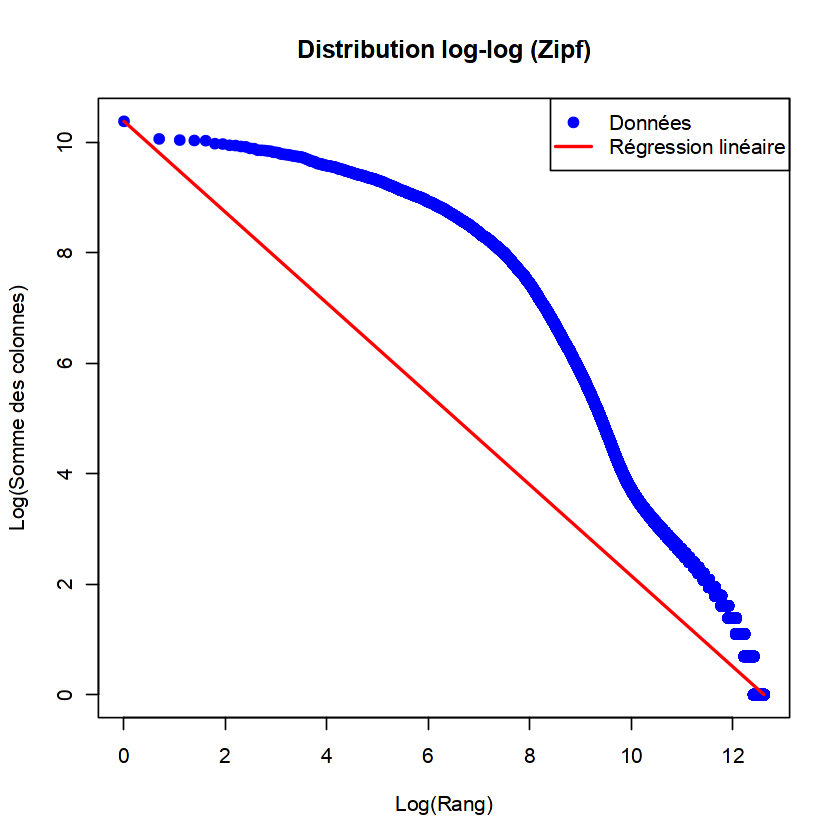

Warning message in create_seurat_object_from_seq_files(data_dir = replica1, sublibrary = "M15", :
“Des gènes en double ont été trouvés et seront supprimés.”


 [1] "bs-ydzT" "bs-ydzT" "bs-ydzW" "bs-yetI" "bs-panE" "bs-yoyK" "bs-gswA"
 [8] "bs-ypuC" "bs-ispA" "bs-estA" "bs-epsK" "bs-epsJ" "bs-spsC"


Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Data is of class dgTMatrix. Coercing to dgCMatrix.”


[1] "Seurat object créé avec succès"
An object of class Seurat 
4422 features across 5461 samples within 1 assay 
Active assay: RNA (4422 features, 0 variable features)
 1 layer present: counts
[1] "Métadonnées :"
[1] "Affichage des 6 premières lignes des métadonnées :"
                           orig.ident nCount_RNA nFeature_RNA well sublibrary
AACAACCA_CCGACAAC_ACTCGTAA   AACAACCA   393.5870          317   A1        M15
AACCGAGA_GTGTTCTA_ACTCGTAA   AACCGAGA  1464.6578          776   A1        M15
AACGTGAT_TATCAGCA_ACTCGTAA   AACGTGAT   178.3111          163   A1        M15
AACTCACC_GACTAGTA_ACTCGTAA   AACTCACC   155.0886          148   A1        M15
AACTCACC_GTACGCAA_ACTCGTAA   AACTCACC   897.9934          536   A1        M15
AAGAGATC_CGCATACA_ACTCGTAA   AAGAGATC   108.0139          115   A1        M15
[1] "Dimensions des métadonnées (nombre de cellules et de colonnes) :"
[1] 5461    5
[1] "Noms des colonnes des métadonnées :"
[1] "orig.ident"   "nCount_RNA"   "nFeature_RNA" "well" 

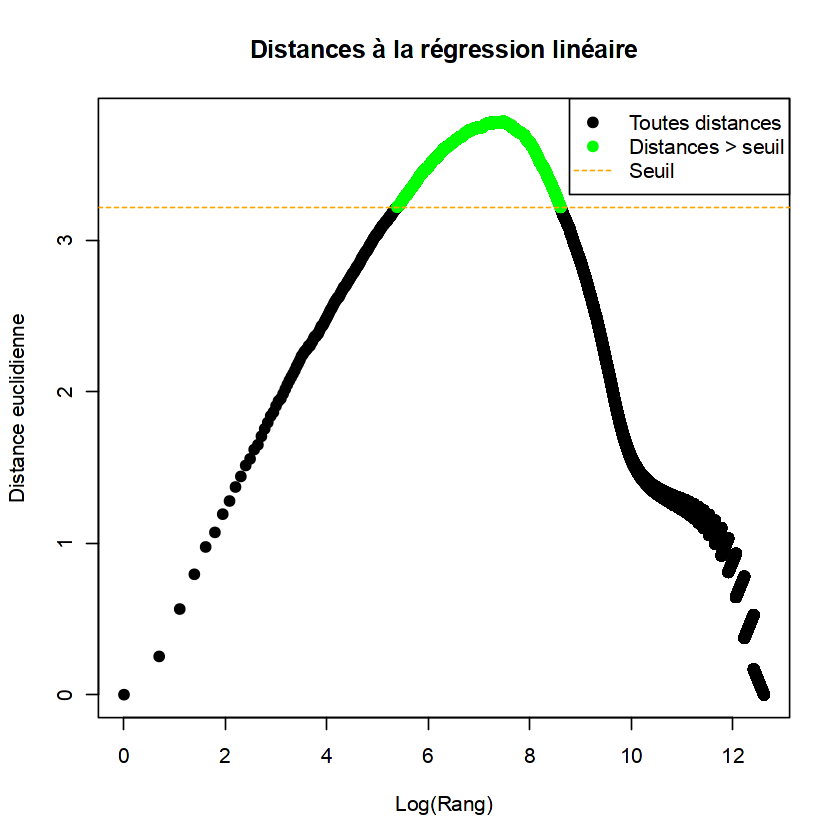

In [5]:
M15  <- create_seurat_object_from_seq_files(
    data_dir = replica1, 
    sublibrary ='M15',
    threshold = 0.85, 
    ribosome_file = path_ribosome_file,
    conversion_file_gene_names = path_conversion_file_gene_names, csv_file_filter = path_csv_file_filter,
    exclude_types = c('rRNA', 'tRNA'),
    #min.cells = 15,
    #min.features = 5
    )




In [ ]:
M15_mRNA_no_filter  <- create_seurat_object_from_seq_files(
    data_dir = replica1, 
    sublibrary ='M15',
    threshold = NULL, 
    ribosome_file = path_ribosome_file,
    conversion_file_gene_names = path_conversion_file_gene_names, csv_file_filter = path_csv_file_filter,
    exclude_types = c('rRNA', 'tRNA'),
    min.cells = 200, #min.cell permet de filtrer les cellules qui ont un nombre de gènes supérieur à min.cell
    min.features = 1000 #min.features permet de filtrer les gènes qui sont exprimés dans un nombre de cellules supérieur à min.features
    )

Warning message in create_seurat_object_from_seq_files(data_dir = replica1, sublibrary = "M15", :
“Des gènes en double ont été trouvés et seront supprimés.”


 [1] "bs-ydzT" "bs-ydzT" "bs-ydzW" "bs-yetI" "bs-panE" "bs-yoyK" "bs-gswA"
 [8] "bs-ypuC" "bs-ispA" "bs-estA" "bs-epsK" "bs-epsJ" "bs-spsC"


Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Data is of class dgTMatrix. Coercing to dgCMatrix.”


In [ ]:
# assigne les metadonnées de densité optique aux cellules

print ("Assigning metadata to cells M15: ")
M15_mRNA_no_filter <- assign_metadata_bacteria_M15(M15_mRNA_no_filter)


In [ ]:
#Test d'affichage des données

M15_mRNA_no_filter 
head(M15_mRNA_no_filter@meta.data)
dim(M15_mRNA_no_filter@meta.data)  # Vérifie le nombre de cellules et de colonnes
colnames(M15_mRNA_no_filter@meta.data)  # Liste les colonnes disponibles



In [ ]:
# Sauvegarde des objets Seurat pour les données brutes avec tous les types d'ARN 
saveRDS(M15_mRNA_no_filter, "7_Article/results/Seurat/M15_mRNA_no_filter.rds")

In [ ]:

M15_mRNA_no_filter <- "7_Article/results/Seurat/M15_mRNA_no_filter.rds"

if (file.exists(M15_mRNA_no_filter)) {
    # Obtenir les informations sur le fichier
    info_fichier <- file.info(M15_mRNA_no_filter)
    
    # Afficher les informations
    cat("✓ Fichier créé avec succès :", M15_mRNA_no_filter, "\n")
    cat("Taille du fichier :", round(info_fichier$size/1024/1024, 2), "MB\n")
    cat("Date de création :", format(info_fichier$mtime, "%Y-%m-%d %H:%M:%S"), "\n")
    
    # Afficher les dimensions de l'objet Seurat
    cat("\nInformations sur l'objet Seurat :\n")
    cat("Nombre de cellules :", ncol(seurat_object_raw), "\n")
    cat("Nombre de gènes :", nrow(seurat_object_raw), "\n")
} else {
    cat("❌ Erreur : Le fichier n'a pas été créé.")


In [ ]:
M14_mRNA_no_filter  <- create_seurat_object_from_seq_files(
    data_dir = replica2, 
    sublibrary ='M14',
    threshold = 0, 
    ribosome_file = path_ribosome_file,
    conversion_file_gene_names = path_conversion_file_gene_names, csv_file_filter = path_csv_file_filter,
    exclude_types = c('rRNA', 'tRNA'),
    #min.cells = 15,
    #min.features = 5
    )

In [ ]:


#repeat for replicate 2
print ("Assigning metadata to cells M14: ")
M14_mRNA_no_filter <- assign_metadata_bacteria_M14(M14_mRNA_no_filter)



In [ ]:


M14_mRNA_no_filter 
head(M14_mRNA_no_filter@meta.data)
dim(M14_mRNA_no_filter@meta.data)  # Vérifie le nombre de cellules et de colonnes
colnames(M14_mRNA_no_filter@meta.data)  # Liste les colonnes disponibles


In [ ]:

saveRDS(M14_mRNA_no_filter, "7_Article/results/Seurat/M14_mRNA_no_filter.rds")

In [ ]:
M14_mRNA_no_filter <- "7_Article/results/Seurat/M14_mRNA_no_filter.rds"

if (file.exists(M14_mRNA_no_filter)) {
    # Obtenir les informations sur le fichier
    info_fichier <- file.info(M14_mRNA_no_filter)
    
    # Afficher les informations
    cat("✓ Fichier créé avec succès :", M14_mRNA_no_filter, "\n")
    cat("Taille du fichier :", round(info_fichier$size/1024/1024, 2), "MB\n")
    cat("Date de création :", format(info_fichier$mtime, "%Y-%m-%d %H:%M:%S"), "\n")
    
    # Afficher les dimensions de l'objet Seurat
    cat("\nInformations sur l'objet Seurat :\n")
    cat("Nombre de cellules :", ncol(seurat_object_raw), "\n")
    cat("Nombre de gènes :", nrow(seurat_object_raw), "\n")
} else {
    cat("❌ Erreur : Le fichier n'a pas été créé.")